In [2]:
# imports
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import scipy
import pandas as pd
from glob import glob as glob
import os
from neo import io
import seaborn as sb
import matplotlib as mpl
import h5py
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
import statsmodels.api as sm
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["font.size"]= 12
plt.rcParams["font.family"] = "Arial"



Load preprocessed data and extract sequence variables

In [3]:
# parameters
animal_id = 'A11' # A11, H07
exp = 'classical' # 'wang or classical
out_path = '/Volumes/Bellet/PhD/Local_Global/processedData/%s/'%animal_id # path to the data

# load preprocessed data
df = pd.read_pickle(os.path.join(out_path,'%s_stims_spikes_dataframe_SU_classical.pkl'%(animal_id)))

In [4]:
# extract basic variables
dates = np.unique(df.date)
ndates = len(dates)
nitems = np.max(df.ItemID)
stimID = np.unique(df.StimID)
nstim = len(stimID)
print(list(df.keys()))
print('Recording dates:',dates)

['PFC_SU', 'Channel', 'TrialID', 'ItemID', 'StimID', 'StimName', 'StimOn', 'blockID', 'blockType', 'date', 'StimDur', 'ISIDur', 'RewardOn']
Recording dates: ['20200226' '20200228' '20200305' '20200306' '20200311' '20200312']


## get variables from each session

In [5]:
soa = 600
Local = []
Global = []
BlockID = []
Blocktype = []
Block = [] # which block
Include = []
Stimon = []
SessionDate = []
StimID = []
Channel = []
sess = 0
blocks = ['aa','aB','bb','bA'] # coded like this in the experiment
for d,date in enumerate(dates):


    
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        SessionDate.append(date)
        Local.append(np.zeros(Ntrials).astype(int))
        for i,ind in enumerate(last_item):
            if df.StimID.iloc[ind]!=df.StimID.iloc[ind-1]: # local deviant = transition of two stim
                Local[sess][i] = 1
        
        BlockID.append(np.array(df.blockID[last_item])) # blockID
        Block.append(np.array(df.blockType[last_item])) # which block (classical experiment: 0,1,2 or 3)
        Blocktype.append(np.zeros(Ntrials).astype(int)) # xx=0 xY=1
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Blocktype[sess][ind] = Local[sess][ind[0]] # blocktype defined by the first habituation trial in block
        
        Global.append((Local[sess]!=Blocktype[sess]).astype(int))
        
        # filter habituation trials
        nhab = 50
        Include.append(np.ones(len(Global[sess])).astype(int))
        for bl in np.unique(BlockID[sess]):
            ind = np.where(BlockID[sess]==bl)[0]
            Include[sess][ind[:nhab]] = 0
            
        Stimon.append(np.array(df.StimOn.iloc[last_item])) # last stim onset times
        StimID.append(np.array(df.StimID.iloc[last_item]))

        
        sess += 1
    # store channel number
    Channel.append(df.Channel[last_item[0]])

Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312


## PSTHs

In [6]:
# load PSTH
MUA = []
MUA_smooth = []
MUAlast = []
sess = 0
nsess = ndates
for d,date in enumerate(dates):
    # get conditions
    last_item = np.where((df.ItemID==3) & (df.date==date) )[0]#& ((df.StimDur+df.ISIDur)==soa))[0]
    Ntrials = len(last_item)
    if Ntrials>0:
        
        print('Day:',date)
        
        # PSTH
        Rb = np.load(os.path.join(out_path,'Rb_seq_SU_%s.npy'%date))
                
        MUA.append(Rb)
        
        # smooth PSTH
        Rb = np.load(os.path.join(out_path,'Rb_seq_gauss_SU_%s.npy'%date))
        MUA_smooth.append(Rb)
        
        # only last stimulus
        Rb = np.load(os.path.join(out_path,'Rb_last_SU_%s.npy'%date))
                
        MUAlast.append(Rb)
        
        sess += 1
        
del Rb#,Rc

# time vector
time_bins_last = np.load(os.path.join(out_path,'time_bins_%s.npy'%dates[0])) # time vector
time_bins = np.load(os.path.join(out_path,'time_bins_seq_%s.npy'%dates[0])) # time vector
time_bins_gauss = np.load(os.path.join(out_path,'time_bins_seq_gauss_%s.npy'%dates[0])) # time vector
binsize = np.round(np.mean(np.diff(time_bins)),3)
time_bins_last = time_bins_last + binsize
time_bins = time_bins + binsize
time_bins_gauss = time_bins_gauss + binsize

Day: 20200226
Day: 20200228
Day: 20200305
Day: 20200306
Day: 20200311
Day: 20200312


0
1
2
3
4
5
6
7
8
9
10
11
12


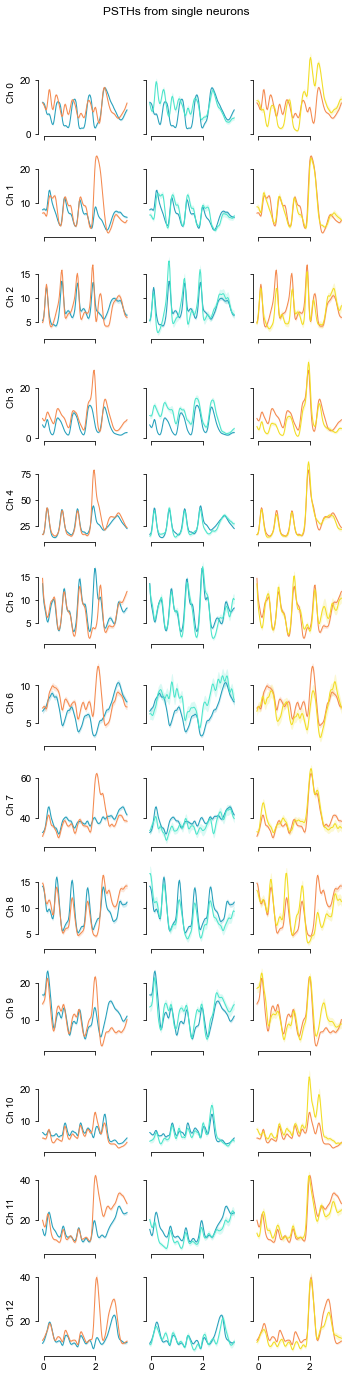

In [9]:
# plot example channel for local effect and global effect 
sess = 0

p_sig = np.arange(MUA[sess].shape[1])
#np.where((P_loc[sess,:]<.05) | (P_glob[sess,:]<0.05))[0]
nsites = len(p_sig)

fig,ax = plt.subplots(nsites,3,figsize=(5,1.5*nsites),sharex=True,sharey='row')
labels = [['xx|xx','xY|xY'],['xx|xx','xx|xY'],['xx|xx','xY|xx']]

loc_colors = ['#229eba','#f4884d'] # xx and xY
glob_colors = ['#229eba','#48e5ca'] # xx|xx and xx|xY
locglob_colors = ['#f4884d','#f2dd20'] # xY|xY and xY|xx
for i,ch in enumerate(p_sig):
    print(ch)
    # LOCAL EFFECT
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,ch,:],0)
        sem = np.std(MUA_smooth[sess][ind,ch,:],0)/np.sqrt(sum(ind))
        ax[i,0].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=loc_colors[c])
        ax[i,0].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[0][c],color=loc_colors[c])
    
    # plot global effect
    for c in range(2):
        ind = (Local[sess]==0) & (Global[sess]==c) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,ch,:],0)
        sem = np.std(MUA_smooth[sess][ind,ch,:],0)/np.sqrt(sum(ind))
        ax[i,1].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=glob_colors[c])
        ax[i,1].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[1][c],color=glob_colors[c])
    
    # plot global+local effect
    for c in range(2):
        ind = (Local[sess]==1) & (Global[sess]==c) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,ch,:],0)
        sem = np.std(MUA_smooth[sess][ind,ch,:],0)/np.sqrt(sum(ind))
        ax[i,2].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=locglob_colors[c])
        ax[i,2].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[2][c],color=locglob_colors[c])
        
    ax[i,0].set_ylabel('Ch %s'%ch)
#ymin,ymax = ax[0,0].get_ylim()
#for i in range(3):
#    ax[0,i].legend()
#    for j in range(4):
#        ax[0,i].plot([j*soa,j*soa],[ymin,ymax],'k',linewidth=1)
sb.despine(trim=True)
fig.suptitle('PSTHs from single neurons')
plt.tight_layout()
plt.subplots_adjust(top=.95)
plt.savefig(os.path.join(out_path,'plots','PSTH_SingleNeurons_%s.pdf'%(animal_id)),bbox_inches='tight')
plt.show()

## Select single neurons from single days

In [7]:
IncludeNeuron = []
for sess in range(nsess):
    IncludeNeuron.append(np.zeros(len(Channel[sess])))
    
IncludeNeuron[0] = np.ones(len(Channel[0]))
for sess in range(nsess-1):
    for i,ch in enumerate(Channel[sess+1]):
        if ch not in Channel[sess]:
            IncludeNeuron[sess+1][i] = 1


In [8]:
sum(np.concatenate(IncludeNeuron))

35.0

## Selection of responsive sites

In [9]:
alpha = 0.05 # for corrected pvalue of ttest

nsess = len(np.unique(dates))

soa = 0.6 # soa of data
#### TIME WINDOWS ####
window_fix = np.arange(0, np.argmin(abs(time_bins)))
window_seq = np.arange( int((abs(time_bins[0])+3*soa)/binsize), int((abs(time_bins[0])*2 + 3*soa)/binsize)) # define averaging window to average firing rate

T_seq = []
P_seq = []
for sess in range(nsess):
    nch = MUA[sess].shape[1]
    P_seq.append(np.zeros(nch))
    T_seq.append(np.zeros(nch))
    for ch in range(nch):
        fix_resp =  np.mean(MUA[sess][:,ch,:][:,window_fix],-1) # average response in fixation period
        seq_resp =  np.mean(MUA[sess][:,ch,:][:,window_seq],-1) # average response to last sequence item
        T_seq[sess][ch], P_seq[sess][ch] = ttest_rel(fix_resp,seq_resp)

    # run false discovery rate procedure on p values per session
    #fdr = multipletests(P_seq[sess], alpha=alpha)
    #p_corr = fdr[1]
    #P_seq[sess] = p_corr
    
# run false discovery rate procedure on p values from included neurons pooled
p_all = []
which_sess = []
for sess in range(nsess):
    p_all.extend(P_seq[sess][IncludeNeuron[sess]==1])
    which_sess.extend(np.ones(sum(IncludeNeuron[sess]==1))*sess)
fdr = multipletests(p_all, alpha=alpha)
p_corr = fdr[1]
for sess in range(nsess):
    P_seq[sess][IncludeNeuron[sess]==1] = p_all[which_sess==sess]



## Anova
Include independent variables Stimulus, Local, Global as well as all two-fold interactions

In [15]:
bins_of_interest = [[0,1]] # times in seconds, after last stimulus


F = []
P = []
for sess in range(nsess):
    #responsive_sites = np.where(P_seq[sess]<0.05)[0]
    responsive_sites = np.where((P_seq[sess]<0.05) & (IncludeNeuron[sess]==1))[0] # include unique, responsive neurons
    print('Session',sess,'Number of responsive sites:',len(responsive_sites))
    F.append(np.zeros((len(bins_of_interest),len(responsive_sites),6)))
    P.append(np.zeros((len(bins_of_interest),len(responsive_sites),6)))
    for i,bins in enumerate(bins_of_interest):
        MUAb = np.mean(MUAlast[sess][:,:,(time_bins_last>bins[0]) & (time_bins_last<bins[1])],-1) # MUA in time period
    
        for j,ch in enumerate(responsive_sites):
            
            # create dataframe
            dframe = pd.DataFrame({'Local': Local[sess][Include[sess]==1],
                              'Global': Global[sess][Include[sess]==1],
                              'Stimulus': StimID[sess][Include[sess]==1],
                              'response': MUAb[Include[sess]==1,ch],})
            
            # perform anova
            model = ols('response ~ C(Stimulus) + C(Local) + C(Global) + C(Local):C(Global) + C(Local):C(Stimulus) + C(Stimulus):C(Global)',data=dframe).fit()
            anova = sm.stats.anova_lm(model,typ=2)
            F[sess][i,j,:] = anova.F[:6]
            P[sess][i,j,:] = anova[anova.columns[-1]][:6]

Session 0 Number of responsive sites: 13
Session 1 Number of responsive sites: 4
Session 2 Number of responsive sites: 7
Session 3 Number of responsive sites: 5
Session 4 Number of responsive sites: 3
Session 5 Number of responsive sites: 3


## FDR

In [44]:
alpha = 0.01
P_flat = P[0].flatten()
for sess in range(nsess-1):
    P_flat = np.concatenate((P_flat,P[sess+1].flatten()))
    
fdr = multipletests(P_flat, alpha=alpha)
Pcorr_flat = fdr[1]
Pcorr = []
nitems_tot = 0
for sess in range(nsess):
    nitems = len(P[sess].flatten())
    Pcorr.append(np.reshape(Pcorr_flat[nitems_tot:nitems_tot+nitems],
                            (len(bins_of_interest),P[sess].shape[1],6)))# reshape back for each session
    nitems_tot += nitems
# pool neurons again
Pcorr_flat = np.concatenate(Pcorr,1)


## Pool sessions

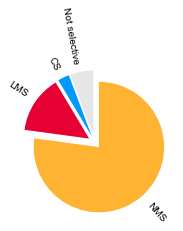

In [46]:
# PLOT

fig,ax = plt.subplots(1,1,figsize=(5,3))

cols = [(0.9,0.9,0.9),(0,0.6,1),(.9,0,.2),(1,0.7,.2)]
labels = ["Not selective","CS", "LMS", "NMS"]

# cs neurons are those without interaction effect and single selectivits for one variable
cs_neurons = np.where((((Pcorr_flat[0,:,0]<alpha) & (Pcorr_flat[0,:,1]>alpha) & (Pcorr_flat[0,:,2]>alpha))  |
       ((Pcorr_flat[0,:,0]>alpha) & (Pcorr_flat[0,:,1]<alpha) & (Pcorr_flat[0,:,2]>alpha)) |
       ((Pcorr_flat[0,:,0]>alpha) & (Pcorr_flat[0,:,1]>alpha) & (Pcorr_flat[0,:,2]<alpha)))& 
       (Pcorr_flat[0,:,3]>alpha) & (Pcorr_flat[0,:,4]>alpha) & (Pcorr_flat[0,:,5]>alpha))[0]

# linear mixed selectivity neurons are those with effect for multiple variables but without interaction
lms_neurons = np.where(((Pcorr_flat[0,:,0]<alpha) & (Pcorr_flat[0,:,1]<alpha) |
                        (Pcorr_flat[0,:,0]<alpha) & (Pcorr_flat[0,:,2]<alpha) |
                        (Pcorr_flat[0,:,1]<alpha) & (Pcorr_flat[0,:,2]<alpha)) & (Pcorr_flat[0,:,3]>alpha) &(Pcorr_flat[0,:,4]>alpha) & (Pcorr_flat[0,:,5]>alpha))[0]
# non-linear mixed selectivity neurons are those with interaction effects
nms_neurons = np.where(((Pcorr_flat[0,:,3]<alpha) | (Pcorr_flat[0,:,4]<alpha) | (Pcorr_flat[0,:,5]<alpha)))[0]

# plot
all_selec = len(cs_neurons)+len(lms_neurons)+len(nms_neurons)
y = np.array([Pcorr_flat.shape[1]-all_selec, len(cs_neurons), len(lms_neurons), len(nms_neurons)])

ax.pie(y, labels = labels, startangle = 90, colors=cols, explode=[0.1,0.1,0.1,0.1], rotatelabels = 270)

plt.show() 

## Plot PSTH of mixed selectivity neurons

Number of LMS stim+loc neurons: 1


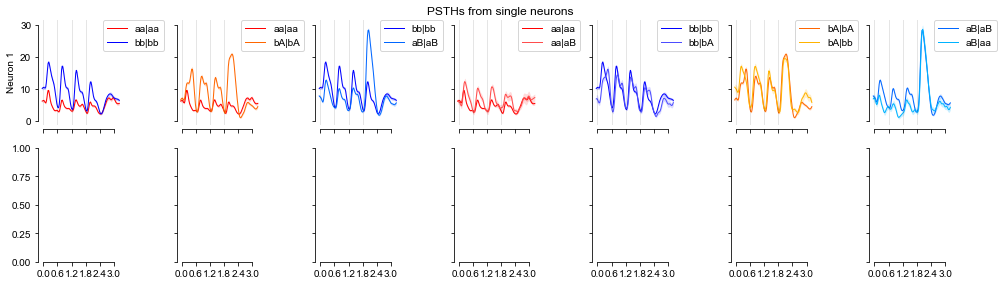

In [48]:
# plot example channel for local effect and global effect 
sess = 0

lms_loc_stim = lms_neurons = np.where(((Pcorr[sess][0,:,0]<alpha) & (Pcorr[sess][0,:,1]<alpha) &  (Pcorr[sess][0,:,2]>alpha)) & 
                                      (Pcorr[sess][0,:,3]>alpha) & (Pcorr[sess][0,:,4]>alpha) & (Pcorr[sess][0,:,5]>alpha))[0]

nsites = len(lms_loc_stim)
print('Number of LMS stim+loc neurons:',nsites)

fig,ax = plt.subplots(nsites+1,7,figsize=(7*2,2*(nsites+1)),sharex=True,sharey='row')
labels = [['aa|aa','bb|bb'],['aa|aa','bA|bA'],['bb|bb','aB|aB'],
          ['aa|aa','aa|aB'],['bb|bb','bb|bA'],
         ['bA|bA','bA|bb'],['aB|aB','aB|aa']]

# define colors
aa_aa = (1,0,0)
aa_ab = (1,0.3,0.3)
ba_ba = (1,0.4,0)
ba_bb = (1,0.7,0)
bb_bb = (0,0,1)
bb_ba = (0.3,0.3,1)
ab_ab = (0,0.4,1)
ab_aa = (0,0.7,1)
stim_colors = [aa_aa,bb_bb] # xx and xY
Aloc_colors = [aa_aa,ba_ba] # xx|xx and xx|xY
Aglob_colors = [aa_aa,aa_ab] # xY|xY and xY|xx
Alocglob_colors = [ba_ba,ba_bb]
Bloc_colors = [bb_bb,ab_ab] # xx|xx and xx|xY
Bglob_colors = [bb_bb,bb_ba] # xY|xY and xY|xx
Blocglob_colors = [ab_ab,ab_aa]

# preselect included neurons
responsive_sites = np.where((P_seq[sess]<0.05) & (IncludeNeuron[sess]==1))[0] # include unique, responsive neurons

for i,ch in enumerate(lms_loc_stim):
    neuron_id = responsive_sites[ch]
    # stimulus selectivity
    for c in range(2):
        ind = (Local[sess]==0) & (Global[sess]==0) & (StimID[sess]==c) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,0].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=stim_colors[c])
        ax[i,0].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[0][c],color=stim_colors[c])
    ax[i,0].legend(bbox_to_anchor=(0.7,1))
    # local selectivity
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (StimID[sess]==0) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,1].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Aloc_colors[c])
        ax[i,1].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[1][c],color=Aloc_colors[c])
    ax[i,1].legend(bbox_to_anchor=(0.7,1))
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (StimID[sess]==1) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,2].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Bloc_colors[c])
        ax[i,2].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[2][c],color=Bloc_colors[c])
    ax[i,2].legend(bbox_to_anchor=(0.7,1))
    # global selectivity
    for c in range(2):
        ind = (Local[sess]==0) & (Global[sess]==c) & (StimID[sess]==0) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,3].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Aglob_colors[c])
        ax[i,3].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[3][c],color=Aglob_colors[c])
    ax[i,3].legend(bbox_to_anchor=(0.7,1)) 
    for c in range(2):
        ind = (Local[sess]==0) & (Global[sess]==c) & (StimID[sess]==1) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,4].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Bglob_colors[c])
        ax[i,4].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[4][c],color=Bglob_colors[c])
    ax[i,4].legend(bbox_to_anchor=(0.7,1))
    # local + global selectivity
    for c in range(2):
        ind = (Local[sess]==1) & (Global[sess]==c) & (StimID[sess]==0) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,5].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Alocglob_colors[c])
        ax[i,5].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[5][c],color=Alocglob_colors[c])
    ax[i,5].legend(bbox_to_anchor=(0.7,1)) 
    for c in range(2):
        ind = (Local[sess]==1) & (Global[sess]==c) & (StimID[sess]==1) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,6].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Blocglob_colors[c])
        ax[i,6].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[6][c],color=Blocglob_colors[c])
    ax[i,6].legend(bbox_to_anchor=(0.7,1))
    
    ax[i,0].set_ylabel('Neuron %s'%ch)
    ymin,ymax = ax[i,0].get_ylim()
    for k in range(7):
        #ax[0,i].legend()
        for j in range(4):
            ax[i,k].plot([j*soa,j*soa],[ymin,ymax],'k',alpha=.1,linewidth=1)
        ax[i,k].set_xticks([0,soa,2*soa,3*soa,4*soa,5*soa]) 
    ax[i,0].set_ylabel('Neuron %s'%ch)
#ymin,ymax = ax[0,0].get_ylim()
#for i in range(3):
#    ax[0,i].legend()
#    for j in range(4):
#        ax[0,i].plot([j*soa,j*soa],[ymin,ymax],'k',linewidth=1)
sb.despine(trim=True)
fig.suptitle('PSTHs from single neurons')
plt.tight_layout()
plt.subplots_adjust(top=.95)

plt.savefig(os.path.join(out_path,'plots','PSTH_SingleNeurons_LMS_%s.pdf'%(animal_id)),bbox_inches='tight')
plt.show()

## Plot classical selectivity neurons

Number of CS neurons: 1


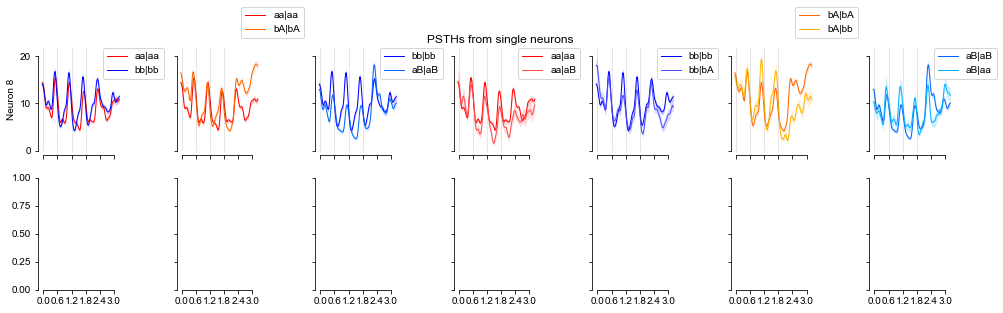

In [52]:
# plot example channel for local effect and global effect 
sess = 0

cs = np.where((((Pcorr[sess][0,:,0]<alpha) & (Pcorr[sess][0,:,1]>alpha) & (Pcorr[sess][0,:,2]>alpha))  |
               ((Pcorr[sess][0,:,0]>alpha) & (Pcorr[sess][0,:,1]<alpha) & (Pcorr[sess][0,:,2]>alpha)) |
               ((Pcorr[sess][0,:,0]>alpha) & (Pcorr[sess][0,:,1]>alpha) & (Pcorr[sess][0,:,2]<alpha)))& 
               (Pcorr[sess][0,:,3]>alpha) & (Pcorr[sess][0,:,4]>alpha) & (Pcorr[sess][0,:,5]>alpha))[0]

nsites = len(cs)
print('Number of CS neurons:',nsites)

fig,ax = plt.subplots(nsites+1,7,figsize=(7*2,2*(nsites+1)),sharex=True,sharey='row')
labels = [['aa|aa','bb|bb'],['aa|aa','bA|bA'],['bb|bb','aB|aB'],
          ['aa|aa','aa|aB'],['bb|bb','bb|bA'],
         ['bA|bA','bA|bb'],['aB|aB','aB|aa']]

# define colors
aa_aa = (1,0,0)
aa_ab = (1,0.3,0.3)
ba_ba = (1,0.4,0)
ba_bb = (1,0.7,0)
bb_bb = (0,0,1)
bb_ba = (0.3,0.3,1)
ab_ab = (0,0.4,1)
ab_aa = (0,0.7,1)
stim_colors = [aa_aa,bb_bb] # xx and xY
Aloc_colors = [aa_aa,ba_ba] # xx|xx and xx|xY
Aglob_colors = [aa_aa,aa_aab] # xY|xY and xY|xx
Alocglob_colors = [ba_ba,ba_bb]
Bloc_colors = [bb_bb,ab_ab] # xx|xx and xx|xY
Bglob_colors = [bb_bb,bb_ba] # xY|xY and xY|xx
Blocglob_colors = [ab_ab,ab_aa]

# preselect included neurons
responsive_sites = np.where((P_seq[sess]<0.05) & (IncludeNeuron[sess]==1))[0] # include unique, responsive neurons

for i,ch in enumerate(cs):
    
    neuron_id = responsive_sites[ch]
    
    # stimulus selectivity
    for c in range(2):
        ind = (Local[sess]==0) & (Global[sess]==0) & (StimID[sess]==c) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,0].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=stim_colors[c])
        ax[i,0].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[0][c],color=stim_colors[c])
    ax[i,0].legend(bbox_to_anchor=(0.7,1))
    # local selectivity
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (StimID[sess]==0) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,1].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Aloc_colors[c])
        ax[i,1].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[1][c],color=Aloc_colors[c])
    ax[i,1].legend(bbox_to_anchor=(0.7,1))
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (StimID[sess]==1) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,2].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Bloc_colors[c])
        ax[i,2].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[2][c],color=Bloc_colors[c])
    ax[i,2].legend(bbox_to_anchor=(0.7,1))
    # global selectivity
    for c in range(2):
        ind = (Local[sess]==0) & (Global[sess]==c) & (StimID[sess]==0) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,3].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Aglob_colors[c])
        ax[i,3].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[3][c],color=Aglob_colors[c])
    ax[i,3].legend(bbox_to_anchor=(0.7,1)) 
    for c in range(2):
        ind = (Local[sess]==0) & (Global[sess]==c) & (StimID[sess]==1) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,4].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Bglob_colors[c])
        ax[i,4].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[4][c],color=Bglob_colors[c])
    ax[i,4].legend(bbox_to_anchor=(0.7,1))
    # local + global selectivity
    for c in range(2):
        ind = (Local[sess]==1) & (Global[sess]==c) & (StimID[sess]==0) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,5].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Alocglob_colors[c])
        ax[i,5].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[5][c],color=Alocglob_colors[c])
    ax[i,5].legend(bbox_to_anchor=(0.7,1)) 
    for c in range(2):
        ind = (Local[sess]==1) & (Global[sess]==c) & (StimID[sess]==1) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,6].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Blocglob_colors[c])
        ax[i,6].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[6][c],color=Blocglob_colors[c])
    ax[i,6].legend(bbox_to_anchor=(0.7,1))
    
    ax[i,0].set_ylabel('Neuron %s'%ch)
    ymin,ymax = ax[i,0].get_ylim()
    for k in range(7):
        #ax[0,i].legend()
        for j in range(4):
            ax[i,k].plot([j*soa,j*soa],[ymin,ymax],'k',alpha=.1,linewidth=1)
        ax[i,k].set_xticks([0,soa,2*soa,3*soa,4*soa,5*soa])
        
    ax[i,0].set_ylabel('Neuron %s'%ch)
#ymin,ymax = ax[0,0].get_ylim()
#for i in range(3):
#    ax[0,i].legend()
#    for j in range(4):
#        ax[0,i].plot([j*soa,j*soa],[ymin,ymax],'k',linewidth=1)
sb.despine(trim=True)
fig.suptitle('PSTHs from single neurons')
plt.tight_layout()
plt.subplots_adjust(top=.95)
plt.savefig(os.path.join(out_path,'plots','PSTH_SingleNeurons_CS_%s.pdf'%(animal_id)),bbox_inches='tight')
plt.show()

## Plot NMS neurons

Number of NMS neurons: 4


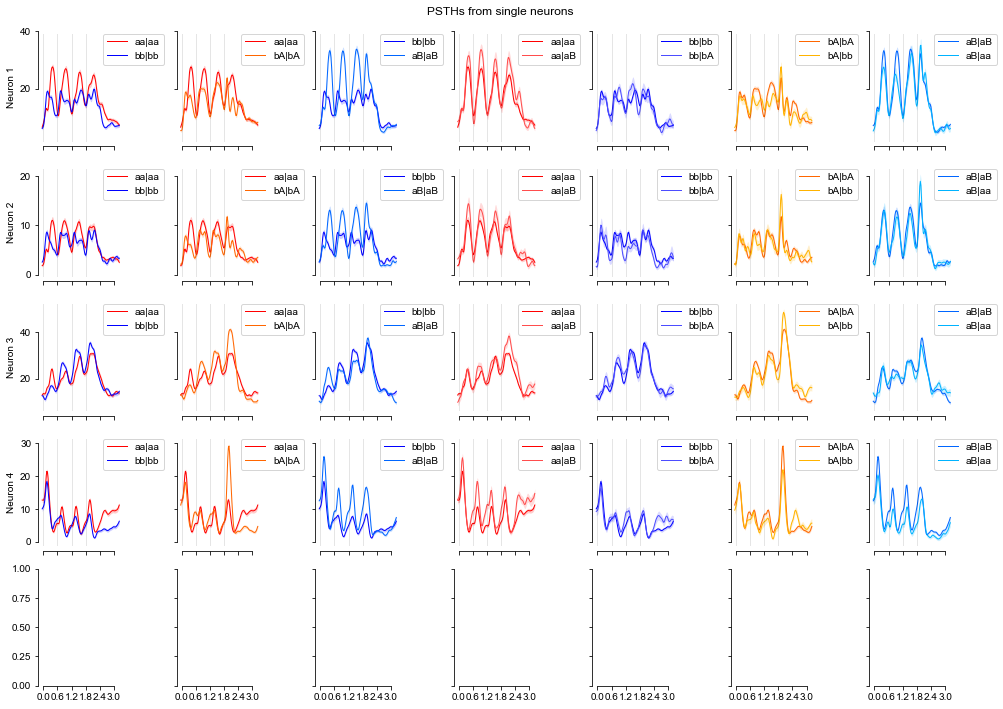

In [51]:
# plot example channel for local effect and global effect 
sess = 3

nms = np.where(((Pcorr[sess][0,:,3]<alpha) | (Pcorr[sess][0,:,4]<alpha) | (Pcorr[sess][0,:,5]<alpha)))[0]

nsites = len(nms)
print('Number of NMS neurons:',nsites)

fig,ax = plt.subplots(nsites+1,7,figsize=(7*2,2*(nsites+1)),sharex=True,sharey='row')
labels = [['aa|aa','bb|bb'],['aa|aa','bA|bA'],['bb|bb','aB|aB'],
          ['aa|aa','aa|aB'],['bb|bb','bb|bA'],
         ['bA|bA','bA|bb'],['aB|aB','aB|aa']]

# define colors
aa_aa = (1,0,0)
aa_ab = (1,0.3,0.3)
ba_ba = (1,0.4,0)
ba_bb = (1,0.7,0)
bb_bb = (0,0,1)
bb_ba = (0.3,0.3,1)
ab_ab = (0,0.4,1)
ab_aa = (0,0.7,1)
stim_colors = [aa_aa,bb_bb] # xx and xY
Aloc_colors = [aa_aa,ba_ba] # xx|xx and xx|xY
Aglob_colors = [aa_aa,aa_ab] # xY|xY and xY|xx
Alocglob_colors = [ba_ba,ba_bb]
Bloc_colors = [bb_bb,ab_ab] # xx|xx and xx|xY
Bglob_colors = [bb_bb,bb_ba] # xY|xY and xY|xx
Blocglob_colors = [ab_ab,ab_aa]

# preselect included neurons
responsive_sites = np.where((P_seq[sess]<0.05) & (IncludeNeuron[sess]==1))[0] # include unique, responsive neurons

for i,ch in enumerate(nms):
    neuron_id = responsive_sites[ch]
    # stimulus selectivity
    for c in range(2):
        ind = (Local[sess]==0) & (Global[sess]==0) & (StimID[sess]==c) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,0].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=stim_colors[c])
        ax[i,0].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[0][c],color=stim_colors[c])
    ax[i,0].legend(bbox_to_anchor=(0.7,1))
    # local selectivity
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (StimID[sess]==0) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,1].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Aloc_colors[c])
        ax[i,1].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[1][c],color=Aloc_colors[c])
    ax[i,1].legend(bbox_to_anchor=(0.7,1))
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (StimID[sess]==1) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,2].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Bloc_colors[c])
        ax[i,2].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[2][c],color=Bloc_colors[c])
    ax[i,2].legend(bbox_to_anchor=(0.7,1))
    # global selectivity
    for c in range(2):
        ind = (Local[sess]==0) & (Global[sess]==c) & (StimID[sess]==0) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,3].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Aglob_colors[c])
        ax[i,3].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[3][c],color=Aglob_colors[c])
    ax[i,3].legend(bbox_to_anchor=(0.7,1)) 
    for c in range(2):
        ind = (Local[sess]==0) & (Global[sess]==c) & (StimID[sess]==1) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,4].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Bglob_colors[c])
        ax[i,4].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[4][c],color=Bglob_colors[c])
    ax[i,4].legend(bbox_to_anchor=(0.7,1))
    # local + global selectivity
    for c in range(2):
        ind = (Local[sess]==1) & (Global[sess]==c) & (StimID[sess]==0) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,5].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Alocglob_colors[c])
        ax[i,5].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[5][c],color=Alocglob_colors[c])
    ax[i,5].legend(bbox_to_anchor=(0.7,1)) 
    for c in range(2):
        ind = (Local[sess]==1) & (Global[sess]==c) & (StimID[sess]==1) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,6].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=Blocglob_colors[c])
        ax[i,6].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[6][c],color=Blocglob_colors[c])
    ax[i,6].legend(bbox_to_anchor=(0.7,1))
    
    ax[i,0].set_ylabel('Neuron %s'%ch)
    ymin,ymax = ax[i,0].get_ylim()
    for k in range(7):
        #ax[0,i].legend()
        for j in range(4):
            ax[i,k].plot([j*soa,j*soa],[ymin,ymax],'k',alpha=.1,linewidth=1)
        ax[i,k].set_xticks([0,soa,2*soa,3*soa,4*soa,5*soa])
sb.despine(trim=True)
fig.suptitle('PSTHs from single neurons')
plt.tight_layout()
plt.subplots_adjust(top=.95)

plt.savefig(os.path.join(out_path,'plots','PSTH_SingleNeurons_NMS_%s.pdf'%(animal_id)),bbox_inches='tight')
plt.show()

In [ ]:

fig,ax = plt.subplots(nsess,len(bins_of_interest),figsize=(6*len(bins_of_interest),nsess*6))

# order: no selectivity, stimulus, local, global, local:global, stimulus:local, stimulus:global
cols = [(0.9,0.9,0.9),(0,0.6,1),(1,0,.4),(1,1,0),(1,0.6,0),(1,0,1),(.7,.3,0),(.6,0,.6)]
labels = ["Not selective","stim", "loc", "glob", "locglob","locstim","nl_locglob","nl_locstim"]

for i in range(len(bins_of_interest)):
    for sess in range(nsess): # per session
        # selective for stimulus only
        stim = np.where(((Pcorr[sess][i,:,0]<alpha) & (Pcorr[sess][i,:,1]>alpha) & (Pcorr[sess][i,:,2]>alpha) & (Pcorr[sess][i,:,3]>alpha) &(Pcorr[sess][i,:,4]>alpha) & (Pcorr[sess][i,:,5]>alpha)))[0]
        # selective for local only
        loc = np.where(((Pcorr[sess][i,:,0]>alpha) & (Pcorr[sess][i,:,1]<alpha) & (Pcorr[sess][i,:,2]>alpha) & (Pcorr[sess][i,:,3]>alpha) &(Pcorr[sess][i,:,4]>alpha) & (Pcorr[sess][i,:,5]>alpha)))[0]
        # selective for global only
        glob = np.where(((Pcorr[sess][i,:,0]>alpha) & (Pcorr[sess][i,:,1]>alpha) & (Pcorr[sess][i,:,2]<alpha) & (Pcorr[sess][i,:,3]>alpha) &(Pcorr[sess][i,:,4]>alpha) & (Pcorr[sess][i,:,5]>alpha)))[0]
        # LMS: local+ global 
        locglob = np.where(( (Pcorr[sess][i,:,0]>alpha) & (Pcorr[sess][i,:,1]<alpha) & (Pcorr[sess][i,:,2]<alpha) & (Pcorr[sess][i,:,3]>alpha) &(Pcorr[sess][i,:,4]>alpha) & (Pcorr[sess][i,:,5]>alpha)))[0]
        # LMS local + stimulus
        locstim = np.where(( (Pcorr[sess][i,:,0]<alpha) & (Pcorr[sess][i,:,1]<alpha) & (Pcorr[sess][i,:,2]>alpha) & (Pcorr[sess][i,:,3]>alpha) &(Pcorr[sess][i,:,4]>alpha) & (Pcorr[sess][i,:,5]>alpha)))[0]
        # NMS: local + global
        nl_locglob = np.where(( (Pcorr[sess][i,:,3]<alpha) &(Pcorr[sess][i,:,4]>alpha) & (Pcorr[sess][i,:,5]>alpha)))[0]
        # NMS local + stimulus
        nl_locstim = np.where(( (Pcorr[sess][i,:,3]>alpha) &(Pcorr[sess][i,:,4]<alpha) & (Pcorr[sess][i,:,5]>alpha)))[0]
        
        # plot
        all_selec = len(stim)+len(loc)+len(glob)+len(locglob)+len(nl_locglob)
        print(all_selec)
        y = np.array([P[sess].shape[1]-all_selec, len(stim), len(loc), len(glob), len(locglob), len(locstim), len(nl_locglob), len(nl_locstim)])
        
        ax[sess,i].pie(y, labels = labels, startangle = 90, colors=cols, explode=[0.2,0.2,0.2,0.2,.2,.2,.2,.2])
        
        #CS.append(cs_neurons)
        #LMS.append(lms_neurons)
        #NMS.append(nms_neurons)
plt.show()    

# Context

In [16]:
from scipy.stats import ttest_ind

## ttest for context
bins = [0,2.5*soa] # times in seconds, after last stimulus


T = []
P = []
for sess in range(nsess):
    responsive_sites = np.where((P_seq[sess]<0.05) & (IncludeNeuron[sess]==1))[0] # include unique, responsive neurons
    print('Session',sess,'Number of responsive sites:',len(responsive_sites))
    T.append(np.zeros(len(responsive_sites)))
    P.append(np.zeros(len(responsive_sites)))
    MUAb = np.mean(MUA[sess][:,:,(time_bins>bins[0]) & (time_bins<bins[1])],-1) # MUA in time period
    
    for j,ch in enumerate(responsive_sites):
        
        # perform ttest
        xx = MUAb[(Include[sess]==1) & (Blocktype[sess]==0),ch]
        xy = MUAb[(Include[sess]==1) & (Blocktype[sess]==1),ch]
        t,p = ttest_ind(xx,xy)
        T[sess][j] = t
        P[sess][j] = p

Session 0 Number of responsive sites: 13
Session 1 Number of responsive sites: 4
Session 2 Number of responsive sites: 7
Session 3 Number of responsive sites: 5
Session 4 Number of responsive sites: 3
Session 5 Number of responsive sites: 3


### FDR

In [27]:
alpha = 0.01
P_flat = P[0].flatten()
for sess in range(nsess-1):
    P_flat = np.concatenate((P_flat,P[sess+1].flatten()))
    
fdr = multipletests(P_flat, alpha=alpha)
Tflat = np.concatenate(T)
Pcorr_flat = fdr[1]
Pcorr = []
nitems_tot = 0
for sess in range(nsess):
    nitems = len(P[sess].flatten())
    Pcorr.append(Pcorr_flat[nitems_tot:nitems_tot+nitems])# reshape back for each session
    nitems_tot += nitems
# pool neurons again
Pcorr_flat = np.concatenate(Pcorr)

In [37]:
print('Fraction of context sensitive neurons: %s/%s'%(int(sum(Pcorr_flat<alpha)),len(Pcorr_flat)))
print('FR increase in xY block: %s/%s'%(int(sum((Pcorr_flat<alpha) & (Tflat<0))),int(sum(Pcorr_flat<alpha))))
print('FR decrease in xY block: %s/%s'%(int(sum((Pcorr_flat<alpha) & (Tflat>0))),int(sum(Pcorr_flat<alpha))))

Fraction of context sensitive neurons: 13/35
FR increase in xY block: 8/13
FR decrease in xY block: 5/13


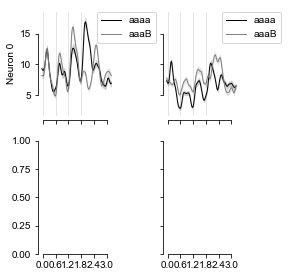

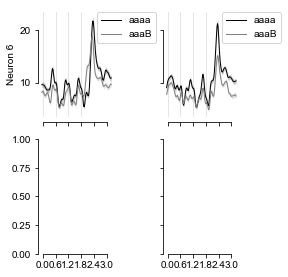

In [43]:
sess = 2
# plot example channel for local effect and global effect 
# preselect included neurons
responsive_sites = np.where((P_seq[sess]<0.05) & (IncludeNeuron[sess]==1))[0] # include unique, responsive neurons

ctx_up = np.where((Pcorr[sess]<alpha) & (T[sess]<0))[0]
ctx_down = np.where((Pcorr[sess]<alpha) & (T[sess]>0))[0]

# FR INCREASE
nsites = len(ctx_up)
fig,ax = plt.subplots(nsites+1,2,figsize=(2*2,2*(nsites+1)),sharex=True,sharey='row')
labels = [['aaaa','aaaB'],['bbbb','bbbA']]
colors = [(0,0,0),(.5,.5,.5)]

for i,ch in enumerate(ctx_up):
    
    neuron_id = responsive_sites[ch]
    
    
    # aa vs ab
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (StimID[sess]==c) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,0].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=colors[c])
        ax[i,0].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[0][c],color=colors[c])
    ax[i,0].legend(bbox_to_anchor=(0.7,1)) 
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (StimID[sess]==(1-c)) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,1].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=colors[c])
        ax[i,1].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[0][c],color=colors[c])
    ax[i,1].legend(bbox_to_anchor=(0.7,1))
   
    
    ax[i,0].set_ylabel('Neuron %s'%ch)
    ymin,ymax = ax[i,0].get_ylim()
    for k in range(2):
        #ax[0,i].legend()
        for j in range(4):
            ax[i,k].plot([j*soa,j*soa],[ymin,ymax],'k',alpha=.1,linewidth=1)
        ax[i,k].set_xticks([0,soa,2*soa,3*soa,4*soa,5*soa])
        
    ax[i,0].set_ylabel('Neuron %s'%ch)

sb.despine(trim=True)
plt.tight_layout()
plt.subplots_adjust(top=.95)
#plt.savefig(os.path.join(out_path,'plots','PSTH_SingleNeurons_CS_%s.pdf'%(animal_id)),bbox_inches='tight')
plt.show()



# FR DECREASE
nsites = len(ctx_down)
fig,ax = plt.subplots(nsites+1,2,figsize=(2*2,2*(nsites+1)),sharex=True,sharey='row')
labels = [['aaaa','aaaB'],['bbbb','bbbA']]
colors = [(0,0,0),(.5,.5,.5)]

for i,ch in enumerate(ctx_down):
    
    neuron_id = responsive_sites[ch]
    
    
    # aa vs ab
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (StimID[sess]==c) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,0].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=colors[c])
        ax[i,0].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[0][c],color=colors[c])
    ax[i,0].legend(bbox_to_anchor=(0.7,1)) 
    for c in range(2):
        ind = (Local[sess]==c) & (Global[sess]==0) & (StimID[sess]==(1-c)) & (Include[sess]==1)
        av = np.mean(MUA_smooth[sess][ind,neuron_id,:],0)
        sem = np.std(MUA_smooth[sess][ind,neuron_id,:],0)/np.sqrt(sum(ind))
        ax[i,1].fill_between(time_bins_gauss+binsize,av-sem,av+sem,linewidth=0,alpha=.2,color=colors[c])
        ax[i,1].plot(time_bins_gauss+binsize,av,linewidth=1,label=labels[0][c],color=colors[c])
    ax[i,1].legend(bbox_to_anchor=(0.7,1))
   
    
    ax[i,0].set_ylabel('Neuron %s'%ch)
    ymin,ymax = ax[i,0].get_ylim()
    for k in range(2):
        #ax[0,i].legend()
        for j in range(4):
            ax[i,k].plot([j*soa,j*soa],[ymin,ymax],'k',alpha=.1,linewidth=1)
        ax[i,k].set_xticks([0,soa,2*soa,3*soa,4*soa,5*soa])
        
    ax[i,0].set_ylabel('Neuron %s'%ch)

sb.despine(trim=True)
plt.tight_layout()
plt.subplots_adjust(top=.95)
#plt.savefig(os.path.join(out_path,'plots','PSTH_SingleNeurons_CS_%s.pdf'%(animal_id)),bbox_inches='tight')
plt.show()